Manuela & Sebastian <br>
Site Remediation CIVE686 <br>

**Objective**

The main objective of this report is exploring how can bioremediation (air sparging) be used on the Elizabeth City, NC site to clean up the concentration of TCE while tracking the degradation products and microbial growth.

**Assumptions**
- We are assuming that the maximum depth the TCE has reached is 35m as below that depth there is bedrock.
- Assuming no sorption given that there is just sand which is composed mainly by silica and the organic matter can be negligible.
- The concentration after the barrier should be 10$\%$ of the initial concentration.

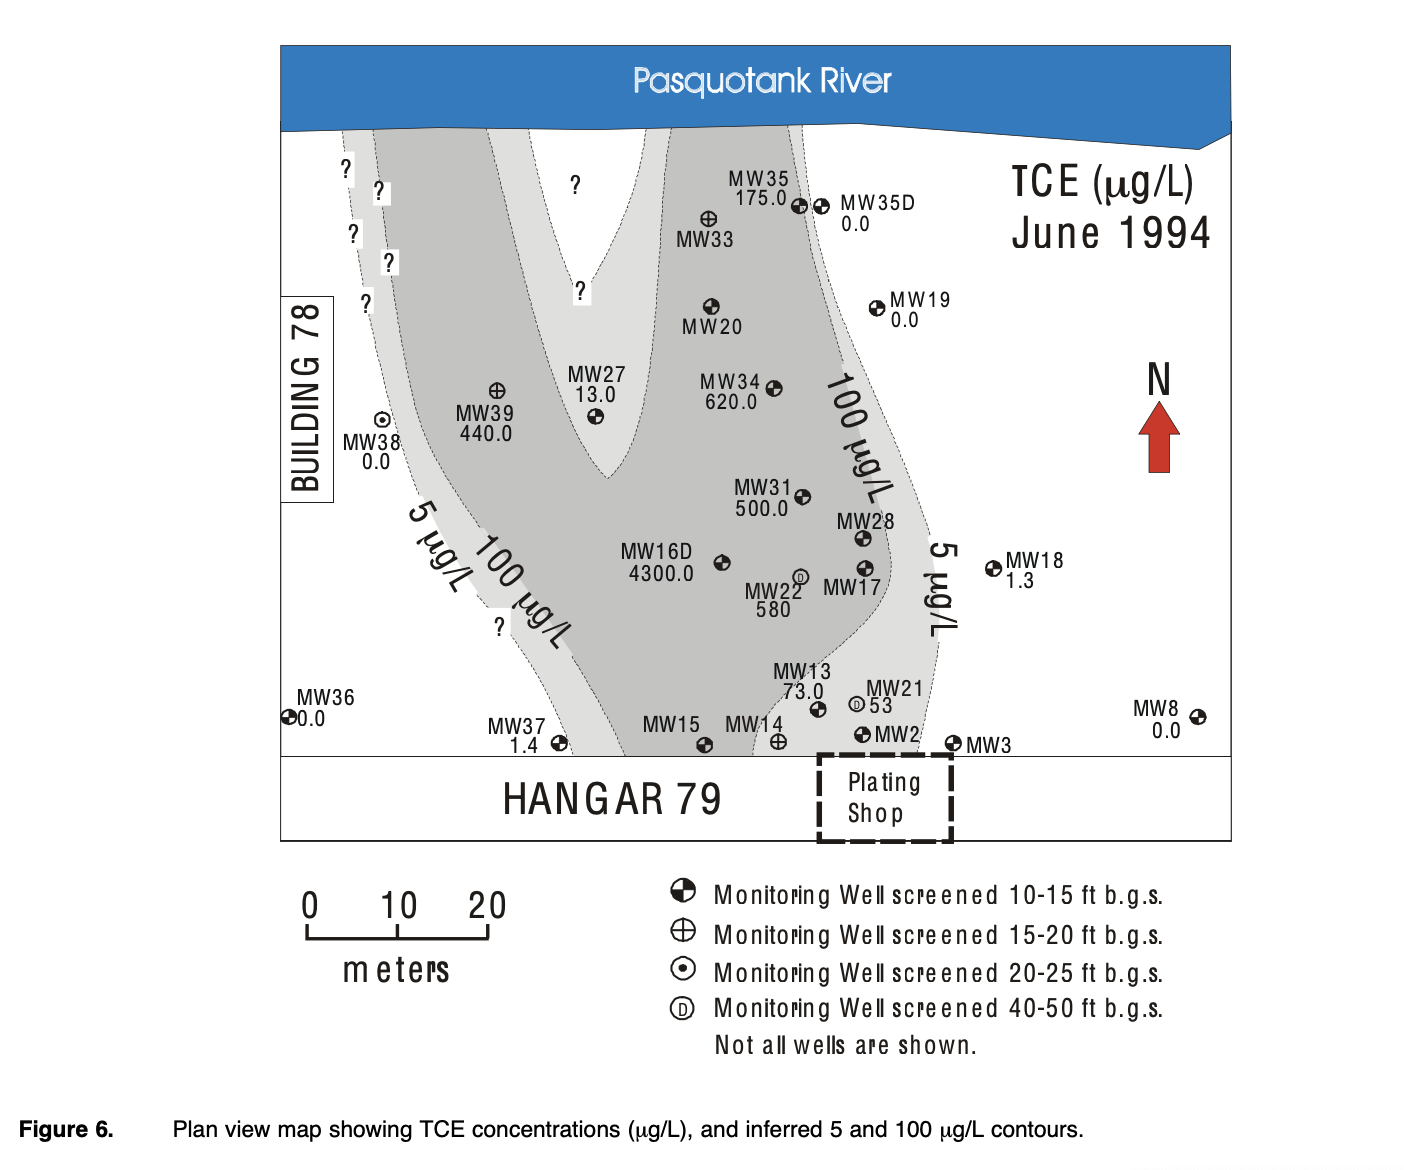
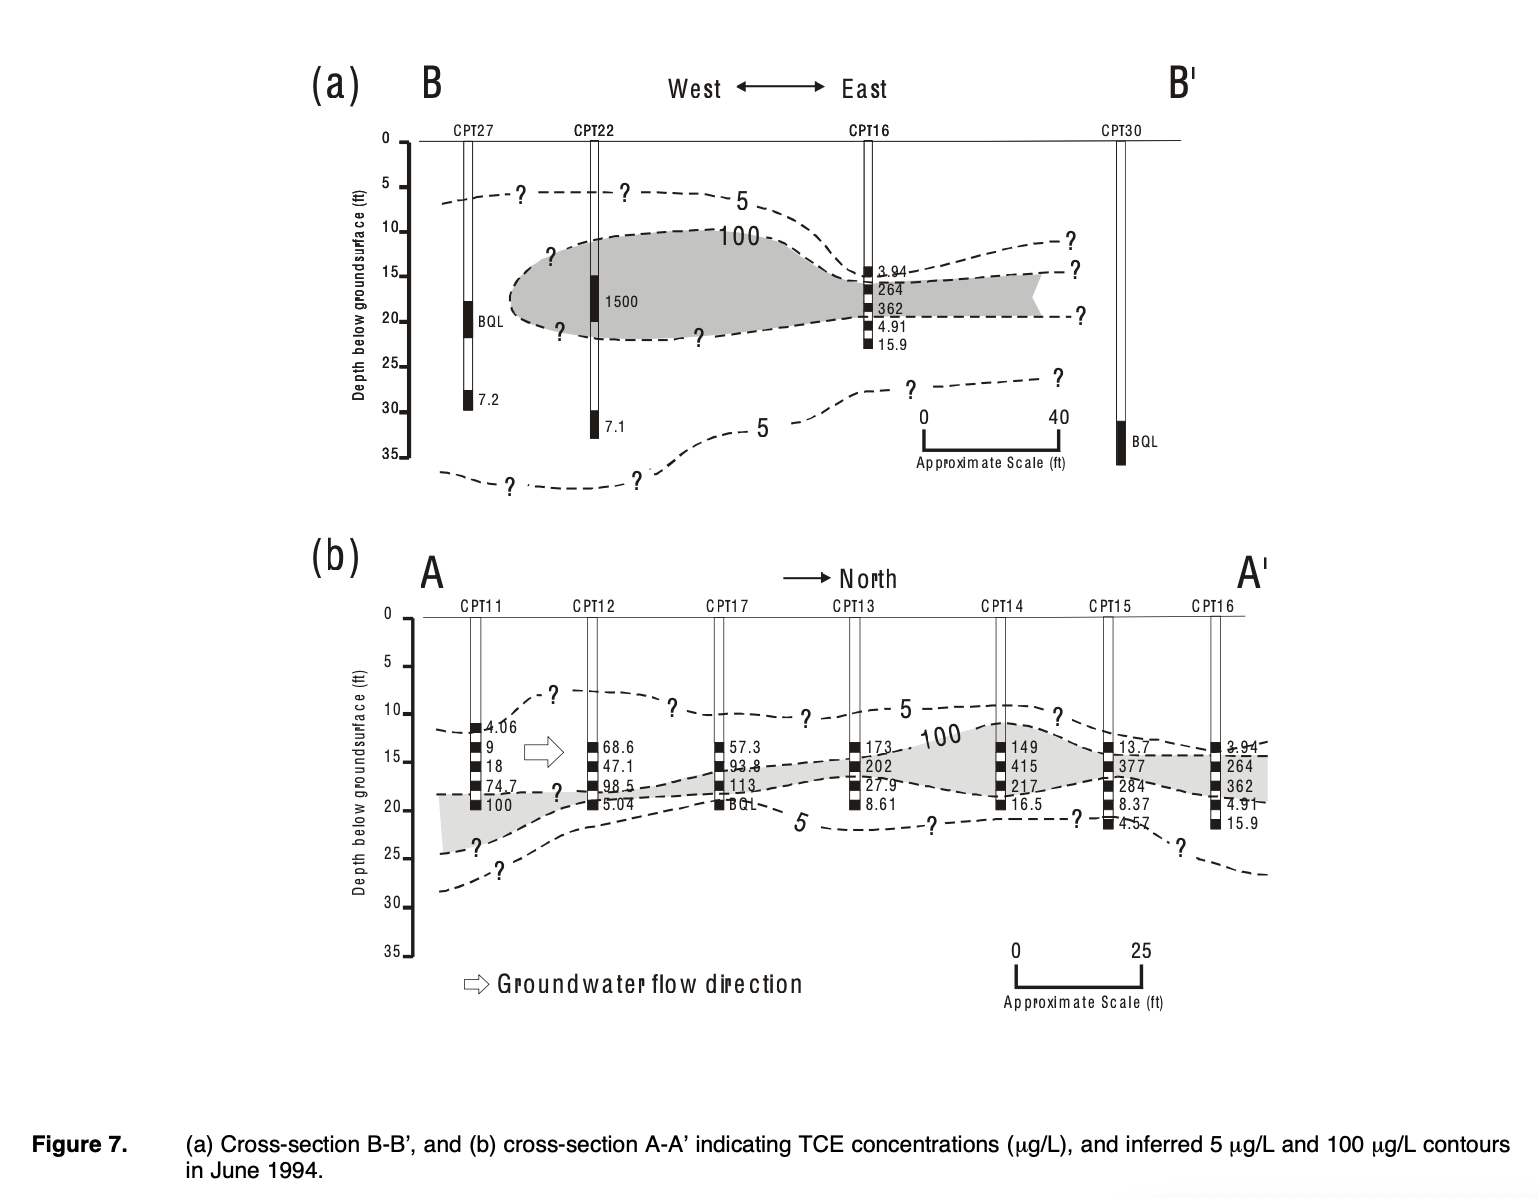
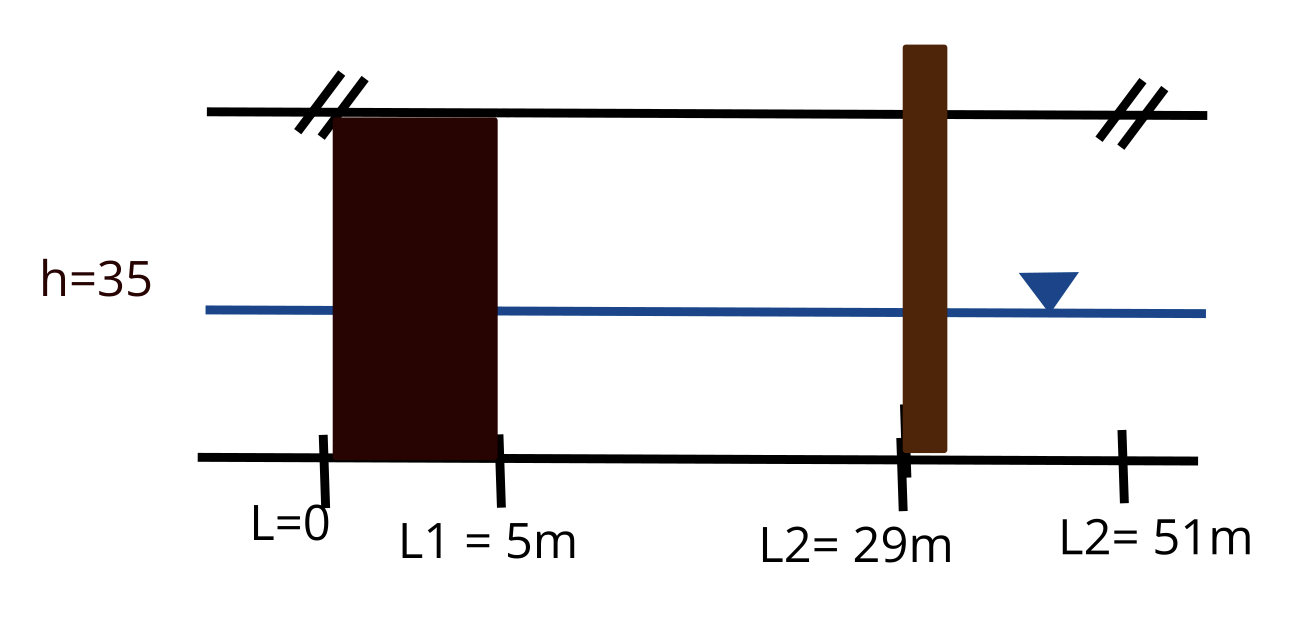

Main equation from L=0 to L=5m
$$    \frac{d C}{dt} = -v_x \frac{dC}{dx} + D_x \frac{d^2C}{dx^2} + k \frac{A}{V} C $$

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
num_wells = 1
L1 = 5 #5m
L2 = 29 #m
L3 = 51 #m
# consider a grid with 
delta_x = 0.25 #m  one grid pont each delta_x meters
delta_t = 60 # one time step each delta_t seconds

# How long do you want to run it?
total_time = 3600*24*10 # let's try total_time seconds

total_grid_points = int(np.ceil(L3//delta_x))
total_time_points = int(np.ceil(total_time//delta_t))
# using the 1D contaminant approach
tce_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of DCE
dce_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of VC
vc_mat= np.zeros(( total_grid_points, total_time_points))

# Mass matrix



# set some boundary conditions, we are assuming an initial concentration of 100mu g/L
co_TCE = 100 *(1/1000) # mg/L 

# Matrix of TCE
tce_mat[:, 0] = co_TCE



# consider the section from 0 to L1 we only have dispersion and difussion as the
# main forces displacing our contaminant TCE, which is inside of a NAPL

mol_mass_TCE = 131.4 #g/mol
aq_sol_TCE = 1.280  * (1/1000)# mg/L
k2 =  3.94e-5# first order constant of degradation
def compute_next_step(curr, prev, next, Dx, v_x, ktav):
    avg_spa = (next - prev)/(2*delta_x)
    diff = (next - 2*curr + prev)/(delta_x**2)
    return curr + delta_t*(-v_x*avg_spa + diff*Dx + ktav*(aq_sol_TCE  - curr))


def compute_next_step_bio(curr, prev, next,  Dx, v_x, k_spa, k_micro):
    avg_spa = (next - prev)/(2*delta_x)
    diff = (next - 2*curr + prev)/(delta_x**2)
    return curr + delta_t*(-v_x*avg_spa + diff*Dx - (k_spa + k_micro)*curr)  

def compute_dce_step(curr_tce, curr_dce):
    x = 0.05#mole transfet coefficient
    k1 = 1.11e-4 # first order constant of degradation
    return curr_dce + (x*k1*curr_tce - k2*curr_dce )*delta_t

def compute_vc_step(curr_dce, curr_vc):
    y = 0.5#mole transfet coefficient
    k3 =  1.23e-4# first order constant of degradation
    return curr_vc + (y*k2*curr_dce - k3*curr_vc )*delta_t


for t in range(total_time_points - 1):
    for i in range(total_grid_points):
        # check for boundary cases
        dis_i = i*delta_x
        if dis_i <= L1:
            v_x = (1 * (1/(24*3600))) #m/day ratio of linear travel distance and travel time
            alpha = 1#m dispersivity coefficient
            D_s = 10**-6# D star or difussion coefficient
            Dx = alpha * v_x + D_s
            ktav = 25.0 * (1/(24*3600)) # per day lumped mass transfer coefficient
            if i == 0:
                tce_mat[i, t + 1] = 0 # concentration at the boundary doesn't change
            else:   
                tce_mat[i, t + 1] = compute_next_step(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], Dx, v_x, ktav)

        elif dis_i < L2:
            v_x = (2 * (1/(24*3600))) #m/day ratio of linear travel distance and travel time
            alpha = 1#m dispersivity coefficient
            D_s = 0# D star or difussion coefficient
            Dx = alpha * v_x + D_s
            tce_mat[i, t + 1] = compute_next_step(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], Dx, v_x, 0)
        else:
            v_x = (2 * (1/(24*3600))) #m/day ratio of linear travel distance and travel time
            alpha = 1#m dispersivity coefficient
            D_s = 0# D star or difussion coefficient
            Dx = alpha * v_x + D_s
            k_spa = 3e-3
            k_micro = 4e-3
            # athing beyond L2
            if i == total_grid_points - 1:
                tce_mat[i , t + 1] = tce_mat[i - 2, t] # anything beyond L3 repeats
                dce_mat[i, t + 1] = dce_mat[i - 2, t]
                vc_mat[i, t + 1] = vc_mat[i -2, t]
            else:
                tce_mat[i, t + 1] = compute_next_step_bio(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], Dx, v_x, k_spa, k_micro)
                dce_mat[i, t + 1] = compute_dce_step(tce_mat[i, t], dce_mat[i, t])
                vc_mat[i, t + 1] = compute_dce_step(dce_mat[i, t], vc_mat[i, t])
                
            if dis_i == L2:
                dce_mat[i, t + 1] = 0
                vc_mat[i, t + 1] = 0 
                

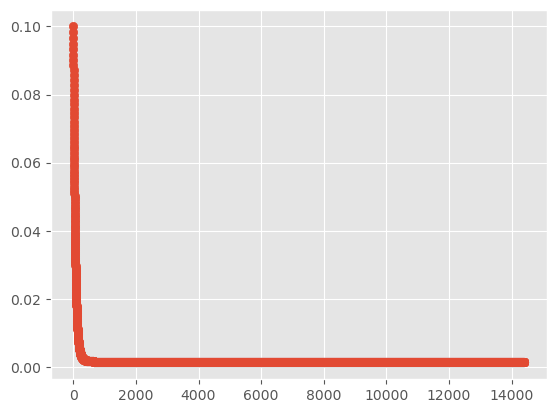

In [138]:
plt.scatter(np.arange(total_time//delta_t), tce_mat[int(L1//delta_x) - 2, :])
#plt.scatter(np.arange(total_time//delta_t), dce_mat[int(L1//delta_x) - 2, :])
#plt.scatter(np.arange(total_time//delta_t), vc_mat[int(L1//delta_x) - 2, :])

plt.show()

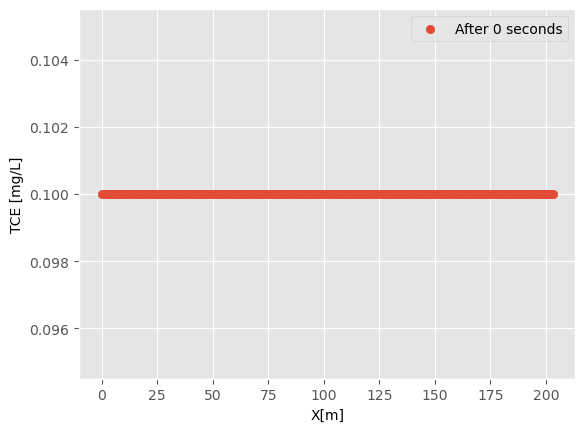

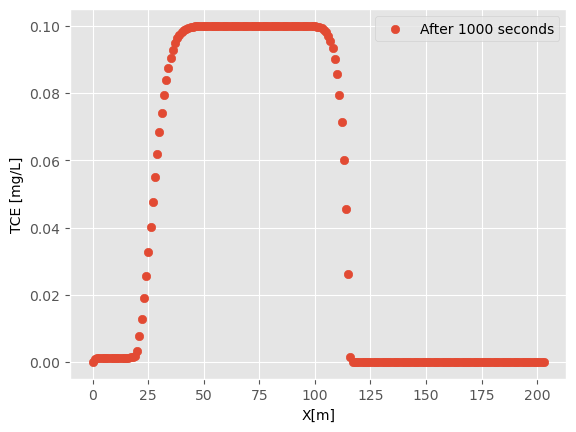

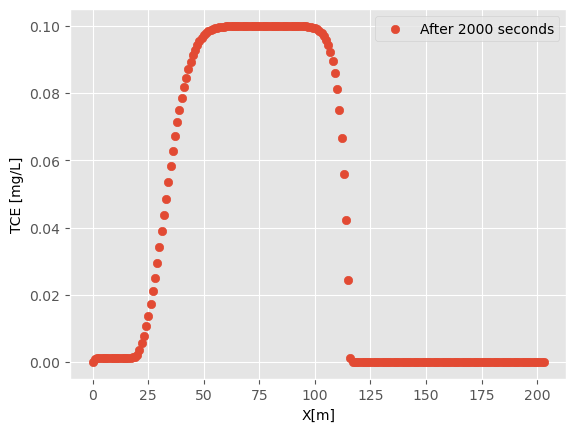

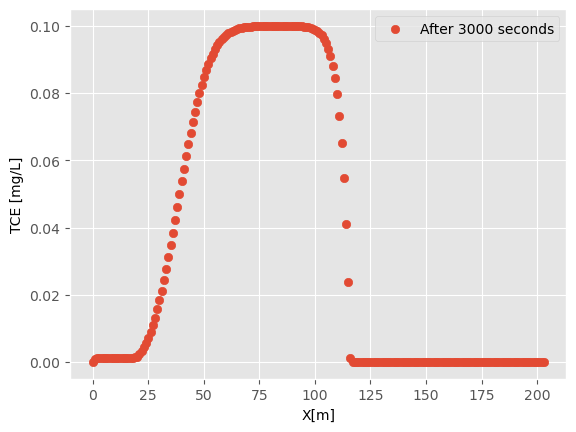

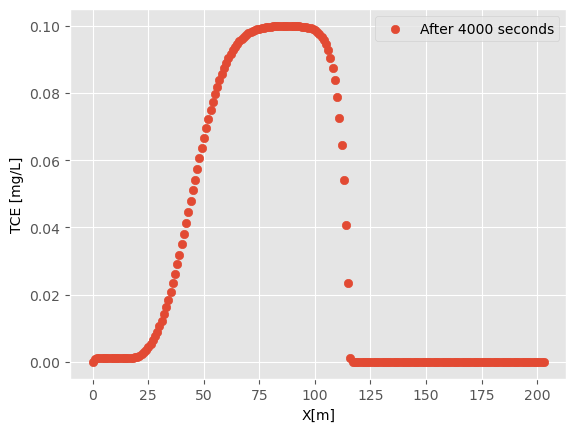

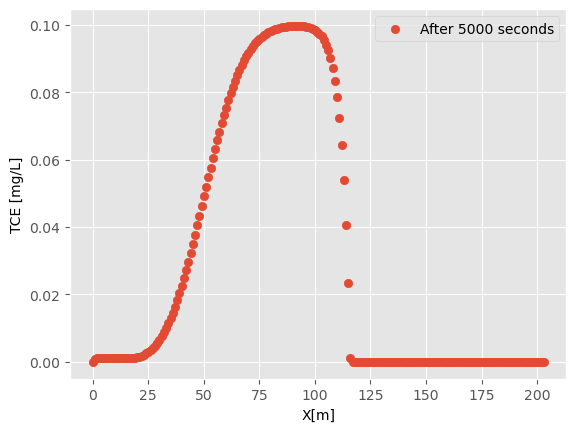

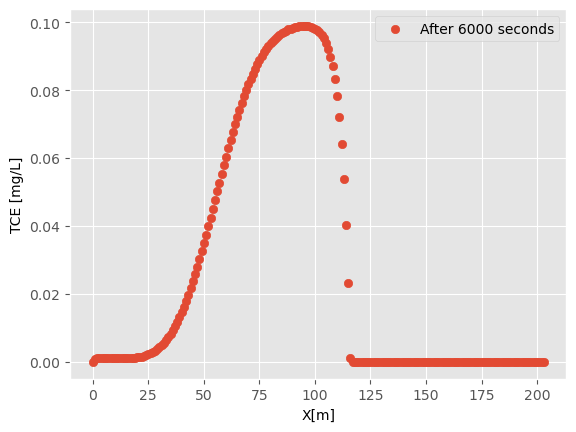

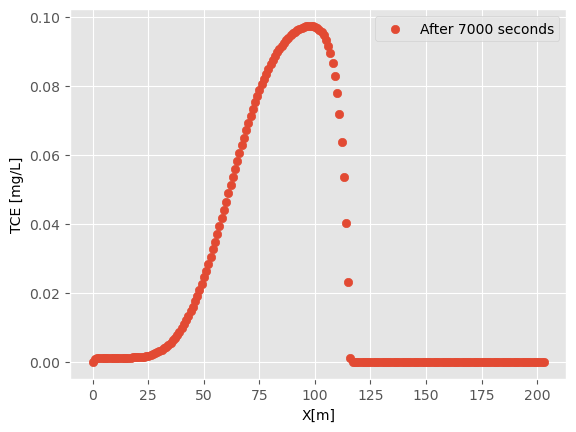

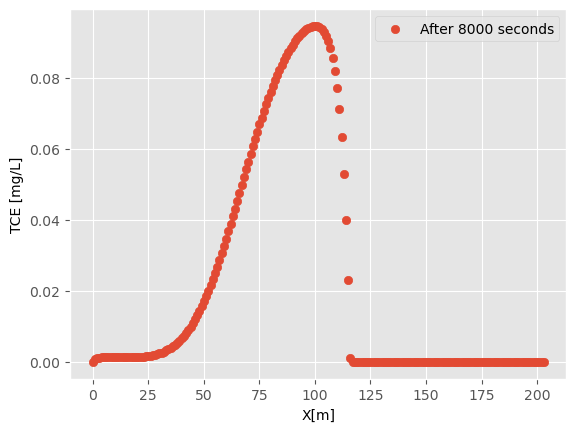

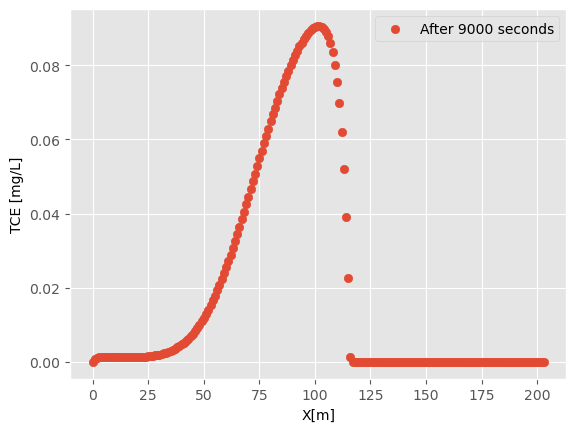

In [139]:
for t in 1000*np.arange(10):
    plt.scatter(np.arange(total_grid_points), tce_mat[:, t ], label=f"After {t} seconds")
    plt.xlabel("X[m]")
    plt.ylabel("TCE [mg/L]")
    plt.legend()
    plt.show()

In [ ]:
# Ratio of Ck_spa and Ck_micro

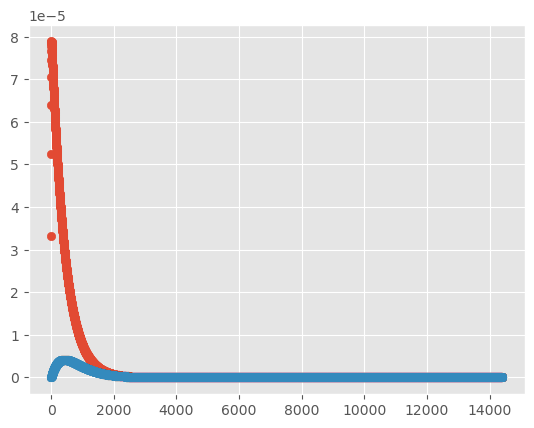

In [150]:
plt.scatter(np.arange(total_time_points), dce_mat[total_grid_points - 2,  :])
plt.scatter(np.arange(total_time_points), vc_mat[total_grid_points - 2,  :])
# plt.scatter(np.arange(total_time_points), tce_mat[total_grid_points - 2,  :]/co_TCE)

plt.show()

In [6]:
L3//delta_x

204.0